# Optimizadores

## SGD

Hasta ahora cada vez que hemos entrenado una red hemos usado como optimizador `torch.optim.SGD`, es decir, el descenso del gradiente estocástico (stochastic gradient descent SGD). Pero cuando vimos la teoría de cómo funciona una red neuronal solo hablamos del descenso del gradiente. Vamos a ver en qué se diferencian ambos

Como hemos visto, dividimos el dataset de datos en batches para meterle a la red el mayor número de datos a la vez. Y hemos visto que cuanto mayor es el tamaño de cada batch mejor, la red obtiene mejores resultados. En un caso ideal, lo mejor es meterle a la red todos los datos del dataset, pero esto normalmente no es posible, por eso se divide en batches, porque normalmente hay muchos más datos que capacidad tiene la red

Vamos a ver la diferencia de entrenar una red metiendo todos los datos en la memoria de la GPU, metiendo batches y metiendo cada vez solo un dato

Vamos a verlo con el ejemplo del dataset Cancer

In [1]:
from sklearn import datasets
import pandas as pd

cancer = datasets.load_breast_cancer()
cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['type'] = cancer['target']
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Creamos un dataset

In [2]:
import torch

class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        cols = [col for col in dataframe.columns if col != 'target']
        self.parameters = torch.from_numpy(dataframe[cols].values).type(torch.float32)
        self.targets = torch.from_numpy(dataframe['type'].values).type(torch.float32)
        self.targets = self.targets.reshape((len(self.targets), 1))

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        parameters = self.parameters[idx]
        target = self.targets[idx]
        return parameters, target

ds = CancerDataset(cancer_df)
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds) - int(0.8*len(ds))], generator=torch.Generator().manual_seed(42))

Creamos la arquitectura de la red neuronal y vemos si tenemos disponible la GPU

In [3]:
from torch import nn

class CancerNeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=[100, 50, 20]):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, hidden_layers[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[0], hidden_layers[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[1], hidden_layers[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[2], num_outputs),
        )
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        logits = self.network(x)
        probs = self.activation(logits)
        return logits, probs

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Creamos una función de entrenamiento donde ya estén incluidas las épocas. Esta función nos devolverá dos listas, una con las pérdidas y otra con la iteracción

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, epochs, num_prints=4):
    size = len(dataloader.dataset)
    model.train()

    losses = []
    iteration = []
    iter = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X, y) in enumerate(dataloader):
            # X and y to device
            X, y = X.to(device), y.to(device)

            # Compute prediction and loss
            logits, probs = model(X)
            loss = loss_fn(probs, y)

            # Add to lists
            losses.append(loss.item())
            iteration.append(iter)
            iter += 1

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % (int(len(dataloader)/num_prints)+1) == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print("Done!")

    return losses, iteration

Creamos el dataloader con todo el dataset, instanciamos la red, la entrenamos y mostramos la evolución de la función de pérdida

Epoch 1
-------------------------------
loss: 1.056492  [    0/  455]
Epoch 2
-------------------------------
loss: 3.218759  [    0/  455]
Epoch 3
-------------------------------
loss: 18.689789  [    0/  455]
Epoch 4
-------------------------------
loss: 2.206242  [    0/  455]
Epoch 5
-------------------------------
loss: 5.156231  [    0/  455]
Epoch 6
-------------------------------
loss: 0.986311  [    0/  455]
Epoch 7
-------------------------------
loss: 2.164669  [    0/  455]
Epoch 8
-------------------------------
loss: 3.208487  [    0/  455]
Epoch 9
-------------------------------
loss: 2.579935  [    0/  455]
Epoch 10
-------------------------------
loss: 1.263271  [    0/  455]
Epoch 11
-------------------------------
loss: 2.289041  [    0/  455]
Epoch 12
-------------------------------
loss: 1.037442  [    0/  455]
Epoch 13
-------------------------------
loss: 1.600371  [    0/  455]
Epoch 14
-------------------------------
loss: 0.990094  [    0/  455]
Epoch 15
-----

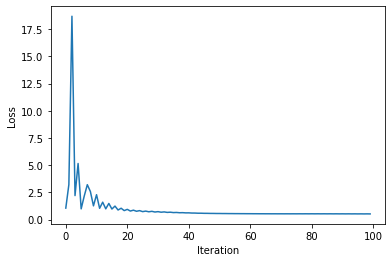

In [6]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

BS_train = len(train_ds)
train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)

# Se define una semilla para que la inicialización de los pesos aleatoria sea siempre la misma
seed = 27
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs=31, num_outputs=1).to(device)

LR = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

losses_all, iteractions_all = train_loop(train_dl, model, loss_fn, optimizer, epochs=100)

# Plot loss vs. iteration
plt.plot(iteractions_all, losses_all)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Lo hacemos ahora para un dataset con un solo dato en cada batch

Epoch 1
-------------------------------
loss: 0.582548  [    0/  455]
loss: 0.493020  [  114/  455]
loss: 0.534528  [  228/  455]
loss: 0.882166  [  342/  455]
Epoch 2
-------------------------------
loss: 0.766721  [    0/  455]
loss: 0.399518  [  114/  455]
loss: 0.438514  [  228/  455]
loss: 0.459391  [  342/  455]
Epoch 3
-------------------------------
loss: 0.288174  [    0/  455]
loss: 0.362757  [  114/  455]
loss: 0.515966  [  228/  455]
loss: 0.002224  [  342/  455]
Epoch 4
-------------------------------
loss: 0.325708  [    0/  455]
loss: 0.693598  [  114/  455]
loss: 0.348110  [  228/  455]
loss: 0.239611  [  342/  455]
Epoch 5
-------------------------------
loss: 0.403256  [    0/  455]
loss: 0.762576  [  114/  455]
loss: 0.019120  [  228/  455]
loss: 0.009778  [  342/  455]
Epoch 6
-------------------------------
loss: 0.021781  [    0/  455]
loss: 0.000293  [  114/  455]
loss: 0.398638  [  228/  455]
loss: 0.407083  [  342/  455]
Epoch 7
-------------------------------


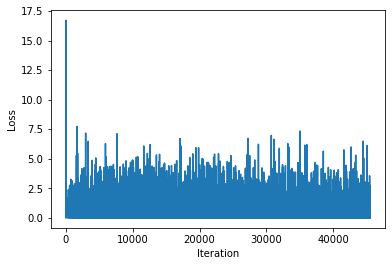

In [7]:
BS_train = 1
train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)

# Se define una semilla para que la inicialización de los pesos aleatoria sea siempre la misma
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs=31, num_outputs=1).to(device)

LR = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

losses_one, iteractions_one = train_loop(train_dl, model, loss_fn, optimizer, epochs=100)

# Plot loss vs. iteration
plt.plot(iteractions_one, losses_one)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Y por último con un dataset de un batch size de 64

Epoch 1
-------------------------------
loss: 1.059701  [    0/  455]
loss: 4.506166  [  192/  455]
loss: 4.726321  [  384/  455]
Epoch 2
-------------------------------
loss: 1.139741  [    0/  455]
loss: 0.990593  [  192/  455]
loss: 0.668562  [  384/  455]
Epoch 3
-------------------------------
loss: 0.852828  [    0/  455]
loss: 1.153293  [  192/  455]
loss: 0.608410  [  384/  455]
Epoch 4
-------------------------------
loss: 0.618310  [    0/  455]
loss: 0.860141  [  192/  455]
loss: 1.075195  [  384/  455]
Epoch 5
-------------------------------
loss: 0.690240  [    0/  455]
loss: 0.890698  [  192/  455]
loss: 0.583555  [  384/  455]
Epoch 6
-------------------------------
loss: 0.798251  [    0/  455]
loss: 0.702855  [  192/  455]
loss: 0.574865  [  384/  455]
Epoch 7
-------------------------------
loss: 0.743511  [    0/  455]
loss: 0.608567  [  192/  455]
loss: 0.539146  [  384/  455]
Epoch 8
-------------------------------
loss: 0.625906  [    0/  455]
loss: 0.508446  [  1

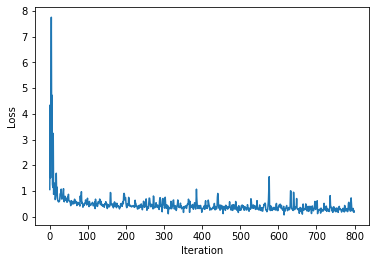

In [9]:
BS_train = 64
train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)

# Se define una semilla para que la inicialización de los pesos aleatoria sea siempre la misma
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model = CancerNeuralNetwork(num_inputs=31, num_outputs=1).to(device)

LR = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

losses_mid, iteractions_mid = train_loop(train_dl, model, loss_fn, optimizer, epochs=100)

# Plot loss vs. iteration
plt.plot(iteractions_mid, losses_mid)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Representamos los 3 juntos para ver la diferencia

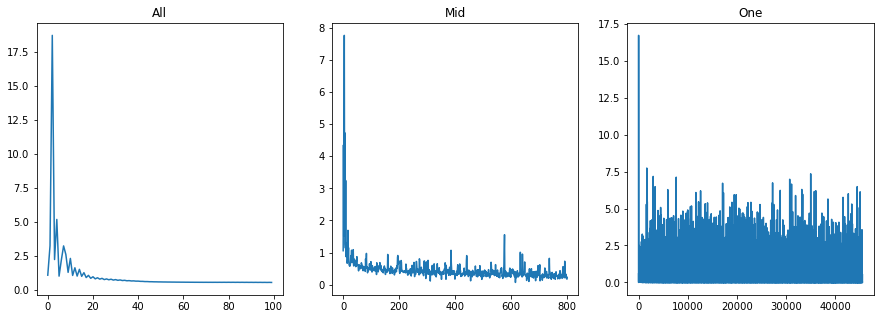

In [14]:
# Subplot with three panels of losses and iterations
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(iteractions_all, losses_all)
axs[0].set_title("All")
axs[1].plot(iteractions_mid, losses_mid)
axs[1].set_title("Mid")
axs[2].plot(iteractions_one, losses_one)
axs[2].set_title("One")
plt.show()

Como se puede ver la función de coste es muy estable cuando se utilizan todos los datos en cada época (all), tiene un poco más de ruido cuando se utiliza un batch size con algunos datos (mid) y tiene mucho ruido cuando en cada iteracción se le mete solo un dato (one)

Esto es debido a que cuando se le meten varios datos a la red, se calcula la función de coste de todos esos datos, se caculan los gradientes y se modifican los parámetros en función de esos gradientes.

Cuando se le meten todos los datos a la red, el cálculo del error se va a hacer para todos, por lo que la actualización de los parámetros se va a hacer de la mejor manera para todos los datos de la red y por eso el entrenamiento es tan estable. Pero a medida que se van disminuyendo la cantidad de datos que se introduce, el cálculo del error se hace para esos datos, por lo que la actualización de los parámetros se hace de la mejor manera para los datos introducidos.

Pero puede darse el caso que entren datos que hagan que haya mucho error, por lo que el gradiente va a ser muy grande, y por tanto haya una gran corrección de los parámetros, más incluso de lo que debería. En la siguiente iteracción pueden entrar otro conjunto de datos que hacen que la anterior corrección no haya sido la mejor posible, por lo que otra vez el error va a ser grande, los gradientes también y la corrección de los parámetros otra vez también sea grande.

Por lo que con cuantos menos datos entrenemos a la red en cada iteracción, habrá más ruido en la evolución de la función de pérdida, hasta llegar al peor caso, en el que si solo se le mete un dato, el error tenga tanta pérdida que ni se pueda llegar a un buen punto de entrenamiento

Es por esto, por lo que cuantos más datos metamos en cada iteracción, es decir, cuanto más grande sea el batch size, mejor será el entrenamiento. Pero la realidad es que casi siempre vamos a tener tantos datos que no van a entrar todos en la memoria de la GPU, por lo que casi siempre vamos a tener que dividir el conjunto de datos en batches

Cuando en cada iteracción se le entrena a la red con todos los datos es cuando de verdad podemos decir que estamos haciendo el descenso por el gradiente. Pero cuando lo que hacemos es meter subconjuntos se dice que se hace un descenso del gradiente estocástico.

Estocástico quiere decir que está sometido al azar y que es objeto de análisis estadístico. Y es lo que está pasando, estamos metiendo subconjuntos de datos, pero no sabemos si son los mejores para entrenar o no, y en cada iteracción el subconjunto va a ser distinto, por lo que la evolución del error no va a ser siempre la misma

Es por eso, por lo que hemos usado el optimizador SGD, porque usando este abarcamos todos los casos, si usamos todo el conjunto de datos de entrenamiento en cada iteracción el SGD pasa a ser un descenso del gradiente (sin ser estocástico), pero si metemos un subconjunto de 1 o más datos, sin llegar a meter todos estamos en el caso del descenso del gradiente estocástico